In [1]:
%load_ext rpy2.ipython

In [8]:
%%R
# loading R packages
library(plyr)
library(dplyr)
library(ggplot2)
library(phyloseq)
library(RColorBrewer)
library(tidyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
physeq = import_biom("../data/otu_table_tax_no211_meta.biom", treefilename = "../data/ssu-aln.bacteria.mask.tre",
                    parseFunction = parse_taxonomy_greengenes)
# Pulling in the phyloseq data

In [44]:
%%R
l2fc<-read.csv("../data/l2fc.csv")
# Pulling in the log2fchange table

In [291]:
%%R
d.plot = l2fc %>%
    select(OTU, Amdmt, Day, l2FC) %>%
    spread(Amdmt, l2FC)
colnames(d.plot) = c("OTU","Day","PyOM","Stover")
# Groups the log2fold change by OTU and day

In [302]:
%%R
FOM <- 2
PyOM <- 2
# Setting the cutoff values for log2fold change for each amendment
# These will be adjusted to test sensitivity to their values

# Adding taxonomy data to the table
d.plot[,5:10] <- tax_table(physeq)[as.character(d.plot[,1]),c(2:7)]
colnames(d.plot) = c("OTU","Day","PyOM","Stover","Phylum","Class","Order","Family","Genus","Species")

# Now I need to group the OTUs by whether or not they make the cutoffs
d.copio <- d.plot[(d.plot$PyOM>PyOM & is.na(d.plot$PyOM)=="FALSE") & (d.plot$Stover>FOM & (is.na(d.plot$Stover)=="FALSE")),]
d.oligo <- d.plot[(d.plot$PyOM>PyOM & is.na(d.plot$PyOM)=="FALSE") & (d.plot$Stover<FOM | (is.na(d.plot$Stover)=="TRUE")),]
d.stover <- d.plot[(d.plot$PyOM<PyOM | is.na(d.plot$PyOM)=="TRUE") & (d.plot$Stover>FOM & (is.na(d.plot$Stover)=="FALSE")),]
#d.copio

In [303]:
%%R
# Making the tables graph-ready

d.copio$Day <- as.factor(d.copio$Day)
d.oligo$Day <- as.factor(d.oligo$Day)
d.stover$Day <- as.factor(d.stover$Day)
# Make Day a factor

d.copio$Group <- "PyOM and Fresh OM"
d.oligo$Group <- "PyOM only"
d.stover$Group <- "Fresh OM only"
# Give them a group title

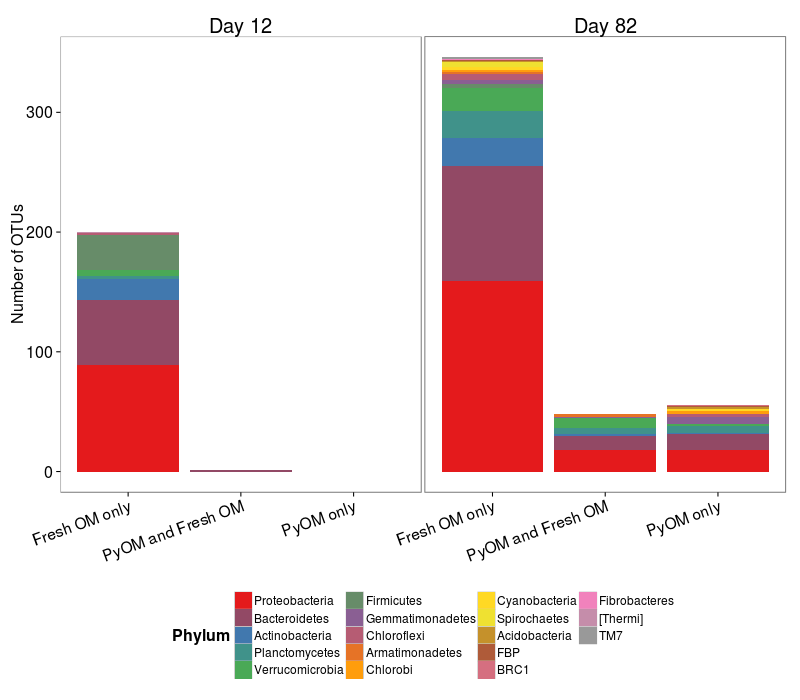

In [304]:
%%R -w 800 -h 700
# Now I want to take these taxa, and make a stacked bar chart based on whether the OTUs fall into these categories

d.all <- rbind(d.copio, d.oligo,d.stover)
d.all$Day = ifelse(d.all$Day==1,"Day 12",ifelse(d.all$Day==2,"Day 82","Day 1"))
# Includes all the amendment responses

p.order <- ddply(d.all,"Phylum", summarise, count = length(PyOM))
p.order <- p.order[order(-p.order$count),] 
p.order <- p.order$Phylum
p.order
# Gets the order of phyla from most to least

d.all$p.order <- factor(d.all$Phylum, c(p.order))
# Adds ordered list

p = ggplot(d.all, aes(Group, fill=p.order)) + geom_bar()
p = p + facet_wrap(~Day)

p = p + theme_bw() +  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
)

p = p + ylab("Number of OTUs") + xlab("")

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 16, angle = 20, hjust = 1, vjust = 1),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size=16),
              legend.position="bottom",
              strip.background = element_blank()
              )


p = p + guides(fill = guide_legend(legend.position="bottom", title = "Phylum", nrow=5))

p = p + theme(legend.text = element_text(size = 12), legend.title = element_text(size = 16))


colourCount = length(unique(d.all$Phylum))
getPalette = colorRampPalette(brewer.pal(14, "Set1"))
p = p + scale_fill_manual(values=getPalette(colourCount))

p


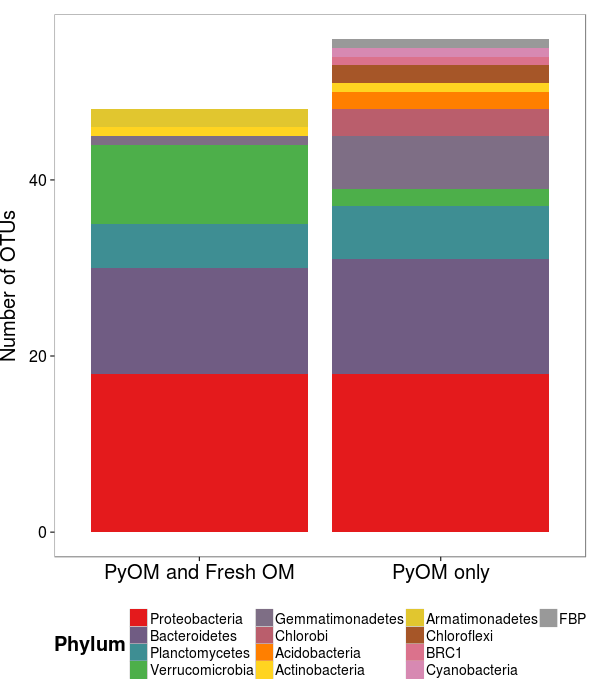

In [305]:
%%R -w 600 -h 700
# Now I want to take these taxa, and make a stacked bar chart based on whether the OTUs fall into these categories

d.all <- rbind(d.copio, d.oligo)
d.all$Day = ifelse(d.all$Day==1,"Day 12",ifelse(d.all$Day==2,"Day 82","Day 1"))
d.all<-d.all[d.all$Day=="Day 82",]

p.order <- ddply(d.all,"Phylum", summarise, count = length(PyOM))
p.order <- p.order[order(-p.order$count),] 
p.order <- p.order$Phylum
p.order
# Gets the order of phyla from most to least

d.all$p.order <- factor(d.all$Phylum, c(p.order))

p = ggplot(d.all, aes(Group, fill=p.order)) + geom_bar()

p = p + theme_bw() +  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
)

p = p + ylab("Number of OTUs") + xlab("")


p = p + theme(axis.text.x = element_text(size = 20),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size=20, vjust=2),
              legend.position="bottom"
              )

p = p + guides(fill = guide_legend(title = "Phylum", size = 20, nrow=4))
p = p + theme(legend.text = element_text(size = 14), legend.title = element_text(size = 20))

colourCount = length(unique(d.all$Phylum))
getPalette = colorRampPalette(brewer.pal(14, "Set1"))
p = p + scale_fill_manual(values=getPalette(colourCount))

p
